<a href="https://colab.research.google.com/github/viphoangdep/license-plate-recognition/blob/main/App.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install easyocr
!pip install ultralytics

In [ ]:
from ultralytics import YOLO
model = YOLO('/content/drive/MyDrive/lisence_yolo_model.pt')

In [ ]:
!unzip /content/drive/MyDrive/dataset.zip -d /content/drive/MyDrive/dataset

Archive:  /content/drive/MyDrive/dataset.zip
replace /content/drive/MyDrive/dataset/dataset/0000_00532_b.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: yes
  inflating: /content/drive/MyDrive/dataset/dataset/0000_00532_b.jpg  
replace /content/drive/MyDrive/dataset/dataset/0000_00532_b.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: yes
  inflating: /content/drive/MyDrive/dataset/dataset/0000_00532_b.txt  
replace /content/drive/MyDrive/dataset/dataset/0000_02187_b.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
import os
import shutil
import random

# Link dataset
dataset_dir = '/content/drive/MyDrive/dataset/dataset'
train_dir = '/content/drive/MyDrive/dataset/dataset/train'
valid_dir = '/content/drive/MyDrive/dataset/dataset/val'

# Create train and valid folder
os.makedirs(train_dir, exist_ok=True)
os.makedirs(valid_dir, exist_ok=True)

# Create images and label for each folder
os.makedirs(os.path.join(train_dir, 'images'), exist_ok=True)
os.makedirs(os.path.join(train_dir, 'labels'), exist_ok=True)
os.makedirs(os.path.join(valid_dir, 'images'), exist_ok=True)
os.makedirs(os.path.join(valid_dir, 'labels'), exist_ok=True)


train_ratio = 0.8

# take the list of
image_files = [f for f in os.listdir(dataset_dir) if f.endswith('.jpg') or f.endswith('.png')]
label_files = [f for f in os.listdir(dataset_dir) if f.endswith('.txt')]

# Divide folder
for image_file in image_files:
    if image_file.replace('.jpg', '.txt') in label_files or image_file.replace('.png', '.txt') in label_files:
        if random.random() < train_ratio:
            # Di chuyển tệp vào thư mục train
            shutil.move(os.path.join(dataset_dir, image_file), os.path.join(train_dir, 'images', image_file))
            shutil.move(os.path.join(dataset_dir, image_file.replace('.jpg', '.txt').replace('.png', '.txt')),
                        os.path.join(train_dir, 'labels', image_file.replace('.jpg', '.txt').replace('.png', '.txt')))
        else:
            # Di chuyển tệp vào thư mục valid
            shutil.move(os.path.join(dataset_dir, image_file), os.path.join(valid_dir, 'images', image_file))
            shutil.move(os.path.join(dataset_dir, image_file.replace('.jpg', '.txt').replace('.png', '.txt')),
                        os.path.join(valid_dir, 'labels', image_file.replace('.jpg', '.txt').replace('.png', '.txt')))

print("Succesful")



0: 480x640 1 license_plate, 168.3ms
Speed: 6.8ms preprocess, 168.3ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


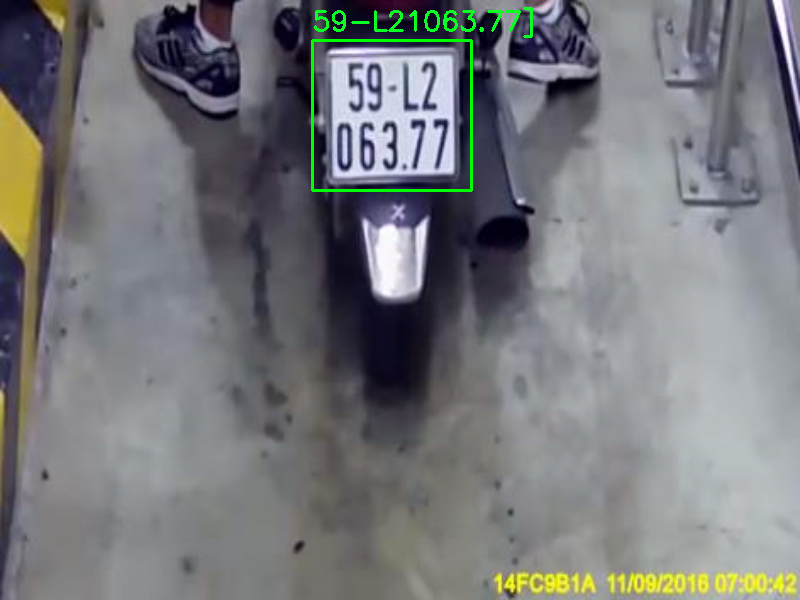

In [ ]:
import cv2
import easyocr
from google.colab.patches import cv2_imshow

# Khởi tạo EasyOCR
reader = easyocr.Reader(['en'])

# Đọc ảnh
image_path = r'/content/drive/MyDrive/dataset/dataset/val/images/0000_05696_b.jpg'  # Thay bằng đường dẫn tới ảnh của bạn
image = cv2.imread(image_path)  # Đọc ảnh từ đường dẫn

# Thay đổi kích thước ảnh (ví dụ: 800x600)
image = cv2.resize(image, (800, 600))

# Thực hiện phát hiện biển số xe với YOLOv8
results = model(image)

# Lặp qua tất cả các đối tượng được phát hiện
for result in results:
    boxes = result.boxes  # Lấy thông tin các bounding box

    for box in boxes:
        # Lấy tọa độ bounding box
        x1, y1, x2, y2 = map(int, box.xyxy[0])  # xyxy là tọa độ của box
        cropped_img = image[y1:y2, x1:x2]  # Cắt hình ảnh biển số xe

        # Sử dụng OCR để đọc văn bản từ biển số xe
        ocr_result = reader.readtext(cropped_img)
        license_plate_text = ''.join([res[1] for res in ocr_result])  # Ghép các dòng text

        # Vẽ bounding box lên ảnh
        cv2.rectangle(image, (x1, y1), (x2, y2), (0, 255, 0), 2)  # Vẽ hình chữ nhật quanh biển số

        # Hiển thị văn bản biển số xe lên ảnh
        cv2.putText(image, license_plate_text, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (36, 255, 12), 2)

# Hiển thị ảnh với kết quả
cv2_imshow(image)  # Sử dụng cv2_imshow để hiển thị ảnh
